# Plotting Streams

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/AllenWLynch/MIRA/HEAD?labpath=docs%2Fsource%2Fnotebooks%2Ftutorial_streamgraphs.ipynb)

**^ Binder launches an interactive session of this tutorial with the environment pre-configured!**

In this brief tutorial, we will demonstrate how to plot different interesting facets of multiomics analysis using the flexible [mira.pl.plot_stream](../plotting/mira.pl.plot_stream.html) interface.

This function is a one-stop shop for all visualization of time-based data in MIRA, and adjusting powerful keyword arguments enables rapid experimentation for the best method to communicate something about your data. Below, we show each of this function's five modes:

* Stream
* Line
* Swarm
* Heatmap
* Scatter

And discuss when to use each. First, import some packages and download the data:

In [1]:
import anndata
import scanpy as sc
import mira
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font',size=12)
mira.utils.pretty_sderr()

mira.datasets.StreamGraphTutorial()
data = anndata.read_h5ad('mira-datasets/shareseq.hair_follicle.joint_representation.lineage_inference.h5ad')

INFO:mira.datasets.datasets:Dataset contents:
	* mira-datasets/shareseq.hair_follicle.joint_representation.lineage_inference.h5ad


This dataset contains differentiating mouse hair follicle cells assayed by SHARE-seq. **We have already performed the prerequisite steps of constructing a low-dimensional latent representation of cells and performing lineage inference**. Check out those tutorials for how those steps were conducted. 

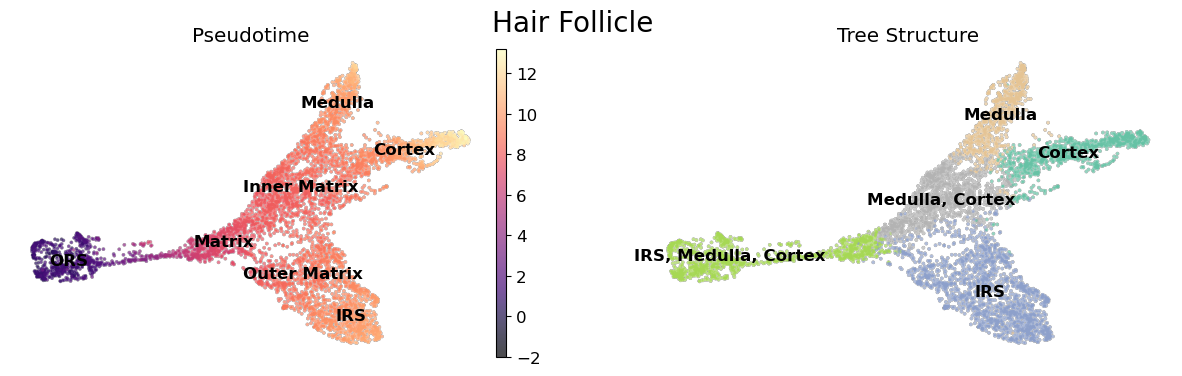

In [2]:
fig, ax = plt.subplots(1,2,figsize=(15,4))
umap_kwargs = dict(add_outline=True, outline_width=(0.1,0), 
                outline_color=('grey', 'white'), legend_loc='on data')

sc.pl.umap(data, color = 'mira_pseudotime', ax = ax[0],
                 title = '', color_map = 'magma', **umap_kwargs,
               show = False, vmin = -2)

sc.pl.umap(data, color = 'true_cell', palette='Set2', 
           legend_loc='on data', title = 'Pseudotime', legend_fontweight=550, 
           frameon = False, legend_fontsize=12,
          alpha = 0., ax = ax[0], show = False)

sc.pl.umap(data, color = 'tree_states', palette = 'Set2', ax = ax[1],
           **umap_kwargs, title = 'Tree Structure', frameon=False, show = False)
fig.suptitle('Hair Follicle', fontsize=20)
plt.show()

### *Stream* mode: Plotting Topics

Streamgraphs are great for showing high-dimensional flows of 1-30 features, like topic compositions! Below, we show how to plot the composition of topics along a differentiation. Here, `hide_feature_threshold` hides topics which aren’t contributing to the cell composition. This significantly cleans up the plot.

Another nifty feature is setting `order` to `ascending`, which stacks the features in a more readable manner.

(<Figure size 1200x600 with 1 Axes>, <AxesSubplot:>)

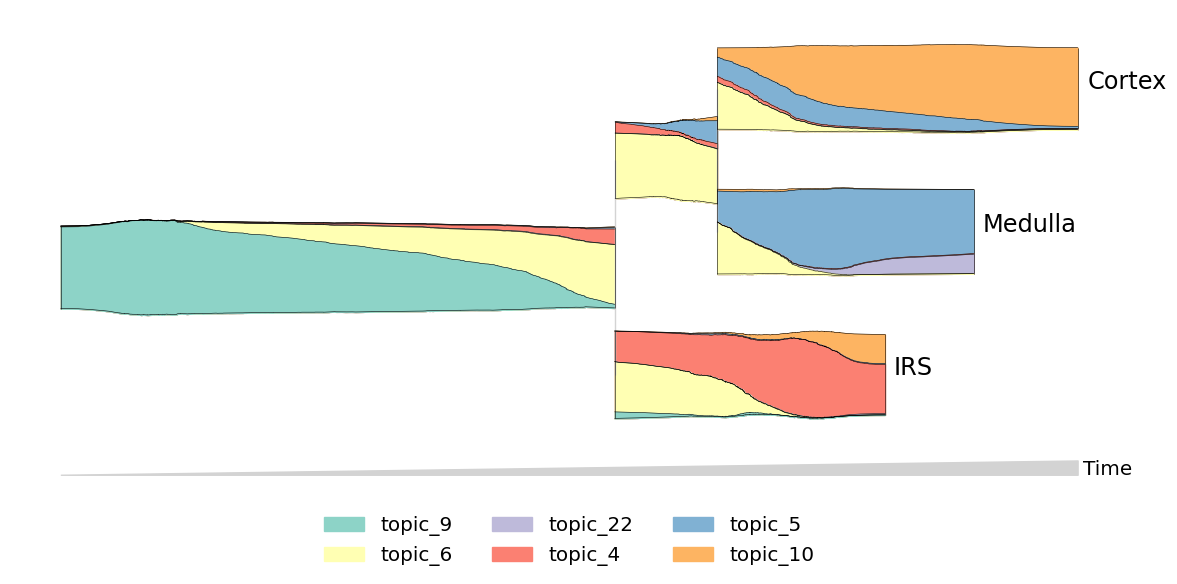

In [3]:
topics = [6,9,10,5,4,22]

mira.pl.plot_stream(data, 
                    data = ["topic_" + str(i) for i in topics], 
                    style = "stream",
                    hide_feature_threshold = 0.03, 
                    window_size = 301, # smooths the lines
                    max_bar_height= 0.8, # makes the streams thicker
                    palette = "Set3",
                    legend_cols = 3, 
                    log_pseudotime = False, 
                    order = 'ascending', # plot features in ascending order with respect to time
                    linewidth=0.4, # makes borders between streams thicker. Userful for light-colored palettes
                    figsize = (12,6)
                ) 

### *Line* mode: Comparing modes

Line graphs are good for comparing 1-2 features where we wish to make quantitative comparisons of trend, like showing two modes for the same gene. 

We provide the gene **LEF1** to `data` twice, then indicate to MIRA to plot the expression, then accessibility of **LEF1**. We set `scale_features` to `True` so that we can compare trends instead of absolute magnitudes.

(<Figure size 700x500 with 1 Axes>, <AxesSubplot:>)

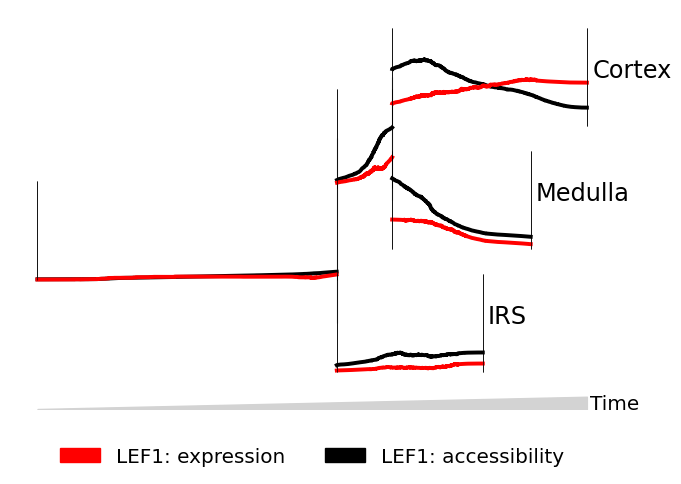

In [4]:
mira.pl.plot_stream(data, 
        data = ["LEF1","LEF1"], # plot two attributes of LEF1
        style = "line", # line style
        layers = ["expression","accessibility"], # first plot expression, then accessibility
        palette = ["red","black"], 
        window_size = 301, # smooooth
        max_bar_height = 0.8,
        scale_features = True, # relative comparison
        clip = 3, # clip outliers
        log_pseudotime = False,
        figsize=(7,5), size = 8)

### *Swarm* mode: Discrete features

Swarm mode is useful for plotting discrete features, like cluster membership. Swarm mode also shows the density of cells over the timecourse.

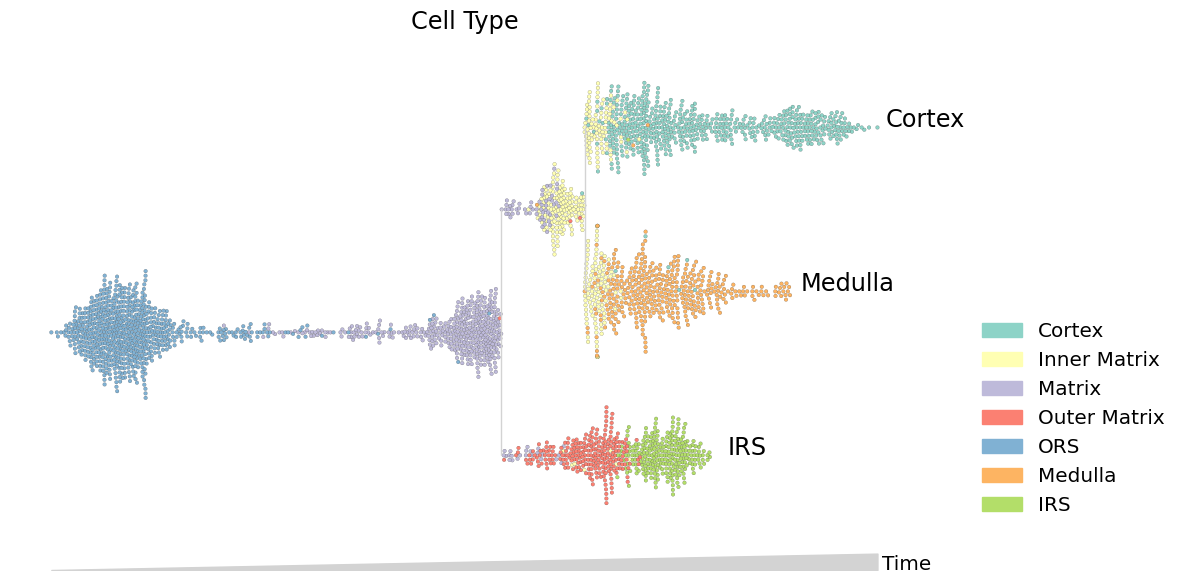

In [5]:
data.obs.true_cell = data.obs.true_cell.astype(str) # convert categorical dtype to string 
mira.pl.plot_stream(data, 
        data = "true_cell", # discrete values
        style = "swarm", # swarm mode
        max_swarm_density = 150, # density of the swarm in Cells/Pseudotime - adjust to prevent overflow of cells into gutters
        palette = "Set3",
        max_bar_height = 0.8, 
        size = 7, 
        log_pseudotime = False,
        title = 'Cell Type',
        figsize = (12,6),
)
plt.show()

### *Split* mode: Visualizing marker genes

Each gene is plotted on its own stream. 

When plotting expression values on a stream, it is a good idea to smooth the counts. From normalized counts, one can do a fast K-NN smoothing via:

In [6]:
data.layers['smoothed'] = data.obsp['connectivities'].dot(data.layers['expression'])

We usually don't take the log-counts of expression data since this reduces the dynamic range of the stream.

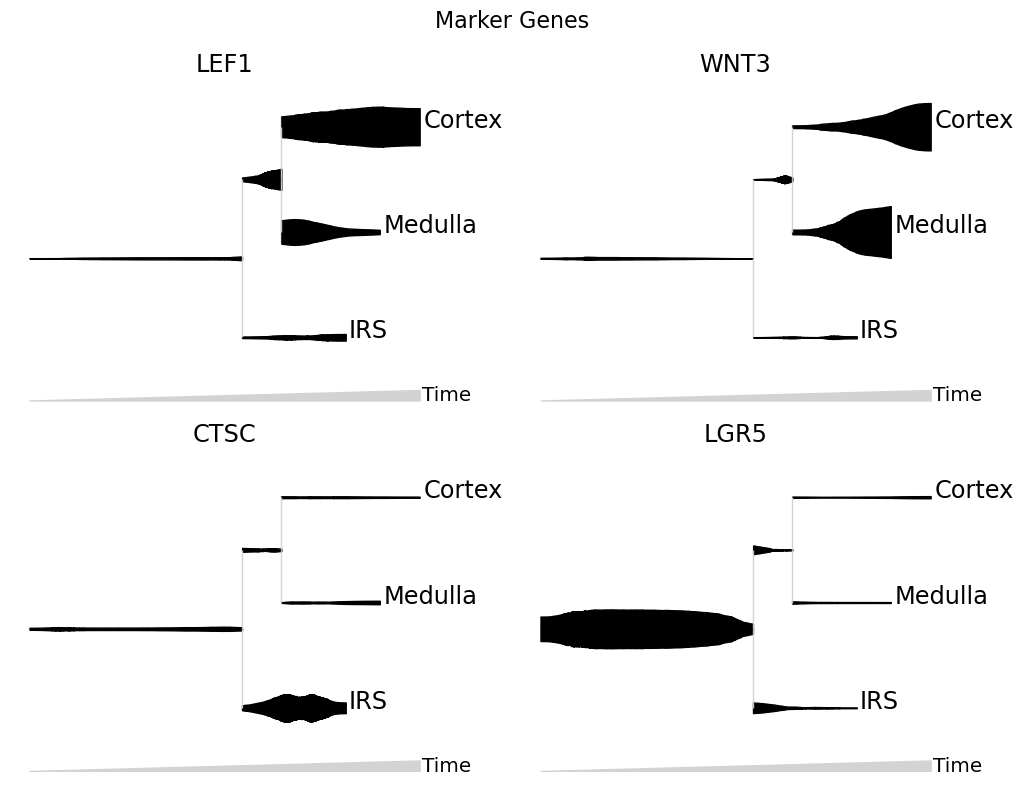

In [7]:
mira.pl.plot_stream(data, 
        data = ["LEF1","WNT3","CTSC","LGR5"], # multiple genes
        layers = 'smoothed', # plot KNN-smoothed values
        style = "stream", 
        split = True, # split features into separate plots
        color = "black",  # "color" overrides "palette" when there is just one feature
        clip = 3, 
        scale_features=True, 
        plots_per_row=2, # how many plots, per row
        log_pseudotime = False, window_size = 301, 
        title  = 'Marker Genes')
plt.show()

### *Heatmap* mode: many features 

Heatmap mode is the best plot for comparing many (>30) features. Note that heatmap mode does not contain lineage tree information, so it is best to subset the tree down to one lineage. You can do this by subsetting the input data to only contain cells along the path you want to see.

Below, the boolean mask `adata.obs.tree_states.str.contains(“Cortex”)` selects for cells whose tree_state attribute indicates that cell is upstream of the cortex lineage:

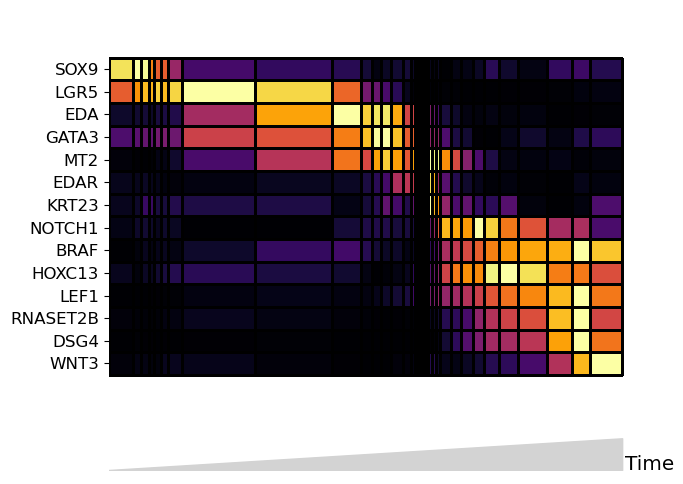

In [8]:
mira.pl.plot_stream(
        data[data.obs.tree_states.str.contains("Cortex")], # subset to one lineage
        data = [gene for gene in list(data.var_names) if not gene in ['CTSC','MREG','SOAT1']], 
        style = "heatmap", # heatmap style
        order = 'ascending', # order the genes automatically
        layers = 'smoothed', # smoothed counts
        window_size = 101, # number of cells/bin
        scale_features=False, 
        tree_structure = False, 
        figsize=(7,5), log_pseudotime = False)
plt.show()

### "Zooming" in on streams

You can subset cells using more complicated filters. For example, to include only cells which may differentiate into Cortex or Medulla cells:

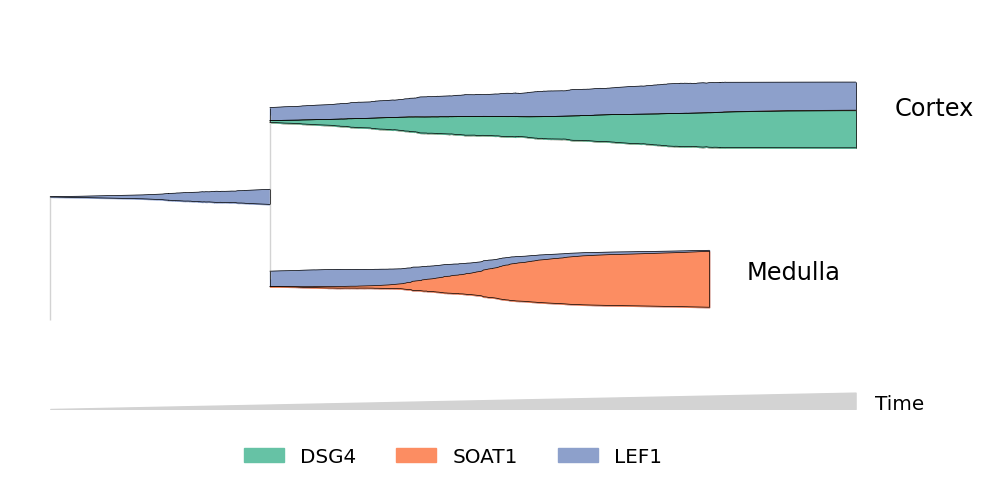

In [9]:
mira.pl.plot_stream(data[~data.obs.tree_states.str.contains("IRS")], 
        data = ["DSG4","SOAT1","LEF1"], 
        style = "stream", 
        layers = 'smoothed',
        window_size = 301,
        scale_features = True, palette='Set2', 
        linewidth=0.5, clip = 5, 
        hide_feature_threshold=0.03,
        max_bar_height = 0.99)
plt.show()

### *Scatter* mode: traditional plots

Finally, scatter mode works for 1-2 features, and can be used to without lineage structue to create more traditional 2-dimensional plots. For example, showing the levels of **Lgr5** and **Lef1** along the path from ORS to Cortex cells:

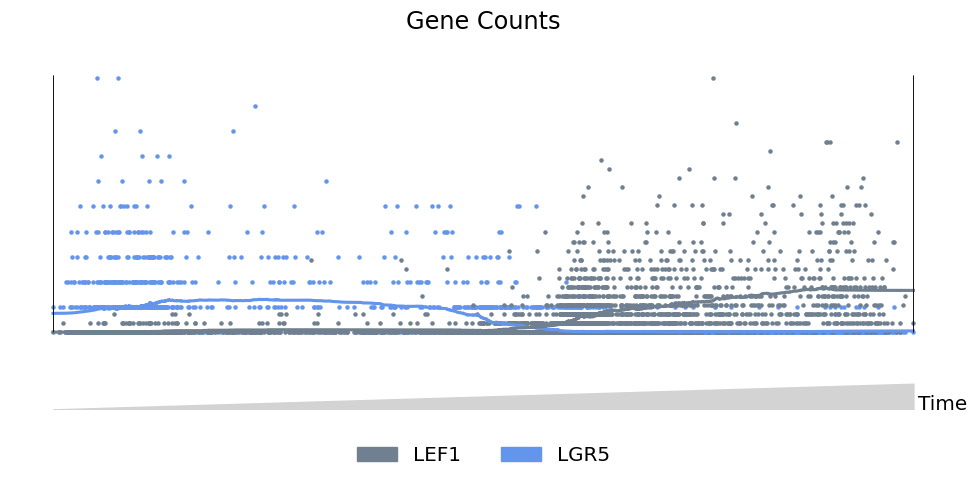

In [10]:
mira.pl.plot_stream(data[data.obs.tree_states.str.contains('Cortex')], 
    data = ['LEF1','LGR5'], 
    style = 'scatter', # scatter mode
    tree_structure=False, # turn off lineage structure
    title = 'Gene Counts',
    palette=['slategrey','cornflowerblue'],
    log_pseudotime=False, 
    window_size = 301,
    max_bar_height=0.99, size = 5)
plt.show()

### Next

If you launch the notebook in binder, you can try making some streams for yourself. This mini-dataset provides a good testing ground to see if streamgraphs are suited for you data.